### Project Overview
Unraveling negative electricity prices in Germany using machine learning models (XGBoost, Random Forest). The project focuses on understanding and predicting negative electricity price events driven by renewable energy oversupply and the inflexibility of non-renewable energy sources. It leverages time-series data from the ENTSO-E Transparency Platform, including electricity generation (renewable: solar, wind; non-renewable: coal, gas), consumption, and day-ahead market prices.


---

### Objectives
1. **Prediction of Negative Price Events**  
   Develop machine learning models to forecast periods of negative electricity prices using historical data.  
   
2. **Quantify Energy Contributions**  
   Analyze and compare the roles of renewable (solar, wind) and non-renewable (coal, gas) energy sources in driving negative price events.  

3. **Pattern Analysis**  
   Identify seasonal, daily, and hourly trends associated with negative electricity prices to support better grid and market management.  

---

### Data Source
**ENTSO-E Transparency Platform**  
- Comprehensive time-series data spanning from January 2022 to August 2024.  
- Covers electricity generation by source, actual and forecasted consumption, and day-ahead market prices.

---

### Data Preprocessing
1. **Cleaning**  
   - Handled missing values in key columns using forward-filling techniques.  
   - Detected and treated outliers in day-ahead prices using the IQR method.  

2. **Feature Engineering**  
   - **Time-Based Features**: Hour of the day, day of the week, and holiday indicators.  
   - **Lag Features**: 24-hour and 48-hour lagged prices.  
   - **Rolling Averages**: Smoothing solar and wind generation to capture long-term trends.  
   - **Combined Wind Energy**: Onshore and offshore aggregated for simplicity.  

3. **Scaling**  
   Applied StandardScaler for normalization of all numerical features.  

---

### Model Development
1. **Algorithms Used**  
   - **XGBoost**: Effective for imbalanced datasets and structured data, with hyperparameter tuning for precision.  
   - **Random Forest**: Robust to noise and provides feature importance for explainability.  

2. **Target Variable**  
   Binary classification:  
   - `1` for negative prices (< 0 €/MWh).  
   - `0` for non-negative prices (≥ 0 €/MWh).  

3. **Imbalance Handling**  
   - Experimented with `scale_pos_weight` in XGBoost.  
   - Applied SMOTE (Synthetic Minority Oversampling Technique) for Random Forest.  

---

### Evaluation Metrics
- **Precision**: Focuses on minimizing false positives.  
- **Recall**: Ensures rare negative events are identified.  
- **F1-Score**: Balances precision and recall for imbalanced data.  
- **Confusion Matrix**: Provides detailed insight into true positives, false positives, and other predictions.  

---

### Key Insights
1. Negative prices are more frequent during high renewable production and low demand periods (e.g., nights, early mornings, weekends).  
2. Gas and coal production significantly decrease during negative price events, but their inflexibility contributes to sustained oversupply.  
3. Seasonal patterns highlight higher negative price occurrences in spring, linked to wind and solar peaks.  


In [ ]:
import pandas as pd

xls = pd.ExcelFile('/content/Thesis Data Final_ANALYSIS.xlsx')
df = pd.read_excel(xls, 'Thesis Data')

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93511 entries, 0 to 93510
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  93511 non-null  object 
 1   Gas                   93491 non-null  float64
 2   Coal                  93499 non-null  float64
 3   Solar                 93491 non-null  float64
 4   Wind Offshore         93499 non-null  float64
 5   Wind Onshore          93491 non-null  float64
 6   Day-ahead Price       93511 non-null  float64
 7    Total Load Forecast  93315 non-null  float64
 8   Actual Load           93511 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.4+ MB


,Time,Gas,Coal,Solar,Wind Offshore,Wind Onshore,Day-ahead Price,Total Load Forecast,Actual Load
0,01.01.2022 00:00 - 01.01.2022 00:15,3353.0,2048.0,2.0,6132.0,25772.0,69.17,42904.0,45093
1,01.01.2022 00:15 - 01.01.2022 00:30,3389.0,2041.0,1.0,6038.0,25686.0,35.61,42533.0,44673
2,01.01.2022 00:30 - 01.01.2022 00:45,3443.0,2038.0,1.0,5961.0,25280.0,23.14,42126.0,44158
3,01.01.2022 00:45 - 01.01.2022 01:00,3433.0,2030.0,1.0,5771.0,25344.0,-3.88,41678.0,43481
4,01.01.2022 01:00 - 01.01.2022 01:15,3319.0,2053.0,1.0,5688.0,24884.0,85.06,41113.0,42621


In [ ]:
df.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
df.shape

(93511, 9)

In [ ]:
df.head()

,Time,Gas,Coal,Solar,Wind Offshore,Wind Onshore,Day-ahead Price,Total Load Forecast,Actual Load
0,01.01.2022 00:00 - 01.01.2022 00:15,3353.0,2048.0,2.0,6132.0,25772.0,69.17,42904.0,45093
1,01.01.2022 00:15 - 01.01.2022 00:30,3389.0,2041.0,1.0,6038.0,25686.0,35.61,42533.0,44673
2,01.01.2022 00:30 - 01.01.2022 00:45,3443.0,2038.0,1.0,5961.0,25280.0,23.14,42126.0,44158
3,01.01.2022 00:45 - 01.01.2022 01:00,3433.0,2030.0,1.0,5771.0,25344.0,-3.88,41678.0,43481
4,01.01.2022 01:00 - 01.01.2022 01:15,3319.0,2053.0,1.0,5688.0,24884.0,85.06,41113.0,42621


In [ ]:
df = df.drop(['Gas', 'Coal'], axis=1)
df.head()


,Time,Solar,Wind Offshore,Wind Onshore,Day-ahead Price,Total Load Forecast,Actual Load
0,01.01.2022 00:00 - 01.01.2022 00:15,2.0,6132.0,25772.0,69.17,42904.0,45093
1,01.01.2022 00:15 - 01.01.2022 00:30,1.0,6038.0,25686.0,35.61,42533.0,44673
2,01.01.2022 00:30 - 01.01.2022 00:45,1.0,5961.0,25280.0,23.14,42126.0,44158
3,01.01.2022 00:45 - 01.01.2022 01:00,1.0,5771.0,25344.0,-3.88,41678.0,43481
4,01.01.2022 01:00 - 01.01.2022 01:15,1.0,5688.0,24884.0,85.06,41113.0,42621


In [ ]:
df['Time'] = df['Time'].str.split(' - ').str[0]
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M')
df.set_index('Time', inplace=True)
missing_values = df.isnull().sum()
df_resampled = df.resample('1H').mean()
df_resampled_filled = df_resampled.fillna(method='ffill')
df_resampled_filled['Negative Price Event'] = df_resampled_filled['Day-ahead Price'] < 0

<ipython-input-7-3d9ea1f91a58>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled_filled = df_resampled.fillna(method='ffill')


In [ ]:
df_2024 = df_resampled_filled['2024-04':'2024-06']
df_2024['Total Renewable Production'] = df_2024['Solar'] + df_2024['Wind Offshore'] + df_2024['Wind Onshore']

<ipython-input-23-0811463124da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Total Renewable Production'] = df_2024['Solar'] + df_2024['Wind Offshore'] + df_2024['Wind Onshore']


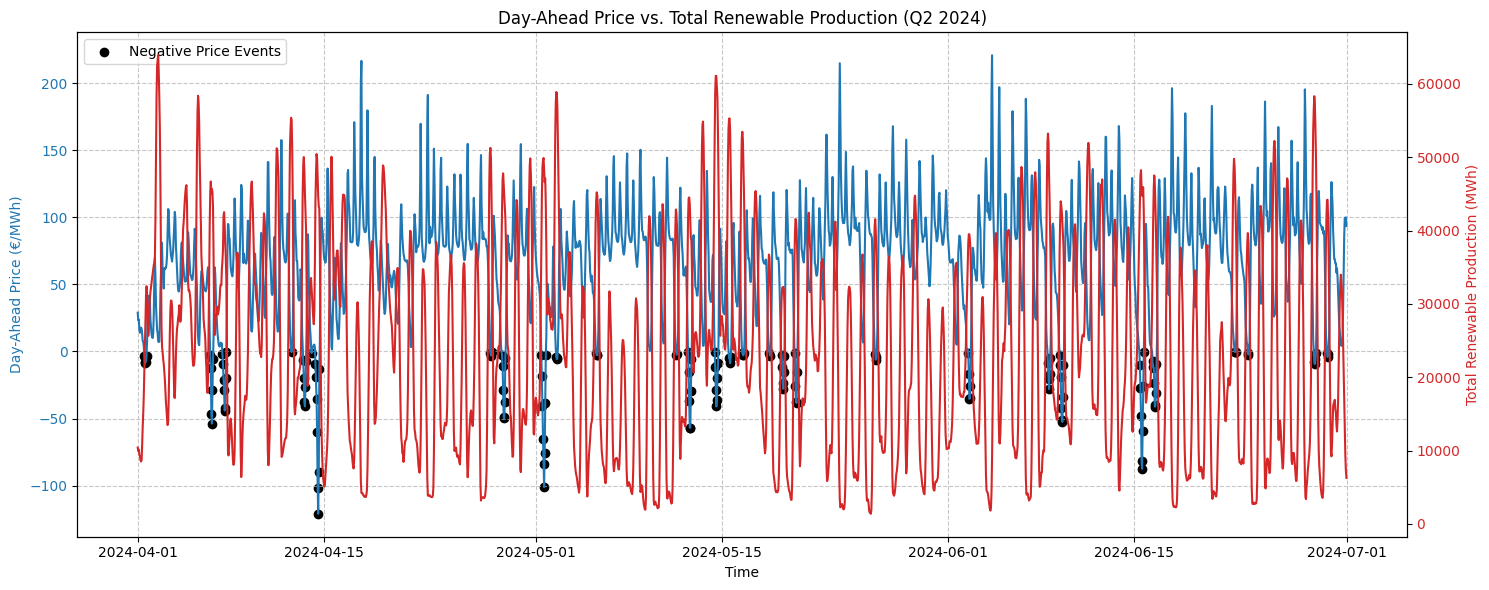

In [ ]:

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 6))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Day-Ahead Price (€/MWh)', color=color)
ax1.plot(df_2024.index, df_2024['Day-ahead Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Renewable Production (MWh)', color=color)
ax2.plot(df_2024.index, df_2024['Total Renewable Production'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

negative_price_indices = df_2024[df_2024['Negative Price Event']].index
ax1.scatter(negative_price_indices, df_2024.loc[negative_price_indices, 'Day-ahead Price'], color='black', marker='o', label='Negative Price Events')

ax1.legend(loc='upper left')
plt.title('Day-Ahead Price vs. Total Renewable Production (Q2 2024)')
fig.tight_layout()
plt.show()


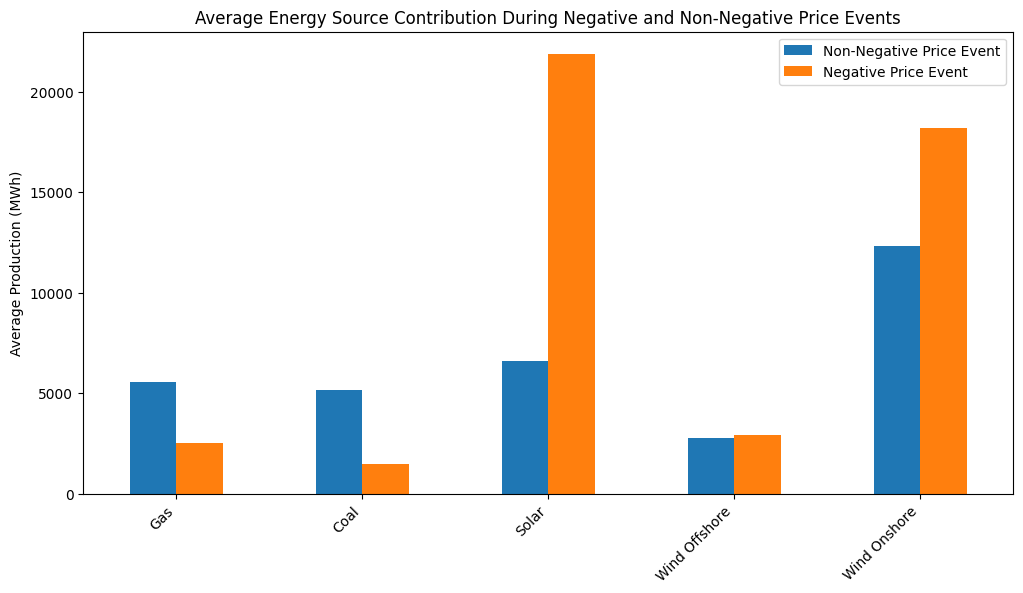

In [ ]:
energy_sources = ['Gas', 'Coal', 'Solar', 'Wind Offshore', 'Wind Onshore']
import matplotlib.pyplot as plt

df_energy = df_resampled_filled[energy_sources + ['Negative Price Event']]
df_energy_grouped = df_energy.groupby('Negative Price Event').mean()
df_energy_grouped = df_energy_grouped.transpose()
ax = df_energy_grouped.plot(kind='bar', figsize=(12, 6))

ax.set_title('Average Energy Source Contribution During Negative and Non-Negative Price Events')
ax.set_ylabel('Average Production (MWh)')
ax.legend(['Non-Negative Price Event', 'Negative Price Event'])
plt.xticks(rotation=45, ha='right')

plt.show()


In [ ]:
df_hourly.head()

,Solar,Day-ahead Price,Total Load Forecast,Actual Load,Day-ahead Price Lag 24,Day-ahead Price Lag 48,Wind Energy,Solar 24h Avg,Wind Energy 24h Avg,Actual Load 24h Avg,Hour,Day of Week,Is Weekend
Time,,,,,,,,,,,,,
2022-01-01 00:00:00,1.25,31.0100,42310.25,44351.25,NaN,NaN,31496.00,NaN,NaN,NaN,0,5,1
2022-01-01 01:00:00,1.00,21.4575,40419.00,41957.75,NaN,NaN,30085.00,NaN,NaN,NaN,1,5,1
2022-01-01 02:00:00,1.00,10.5350,39095.75,40888.00,NaN,NaN,28681.00,NaN,NaN,NaN,2,5,1
2022-01-01 03:00:00,1.00,9.2575,38066.50,39964.00,NaN,NaN,27402.25,NaN,NaN,NaN,3,5,1
2022-01-01 04:00:00,1.00,3.6050,38188.25,39733.50,NaN,NaN,26095.50,NaN,NaN,NaN,4,5,1


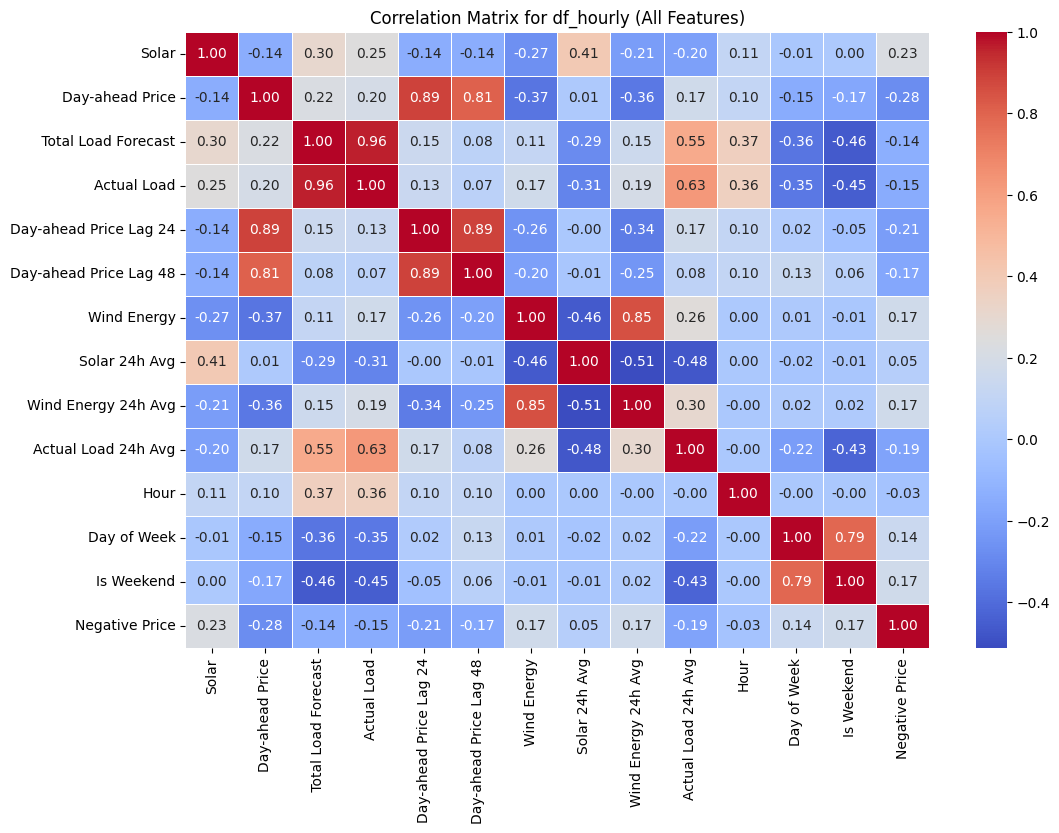

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df_hourly.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for df_hourly (All Features)')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance


df_hourly['Negative Price'] = (df_hourly['Day-ahead Price'] < 0).astype(int)

In [ ]:
X = df_hourly.drop(['Day-ahead Price', 'Negative Price'], axis=1)
y = df_hourly['Negative Price']

In [ ]:
X.loc['2022-01-04']

,Solar,Total Load Forecast,Actual Load,Day-ahead Price Lag 24,Day-ahead Price Lag 48,Wind Energy,Solar 24h Avg,Wind Energy 24h Avg,Actual Load 24h Avg,Hour,Day of Week,Is Weekend
Time,,,,,,,,,,,,
2022-01-04 00:00:00,2.00,53777.50,51191.00,0.9475,54.0000,26638.50,913.302083,36835.187500,60853.697917,0,1,0
2022-01-04 01:00:00,2.00,51767.50,48913.50,4.2350,41.0000,25053.00,913.343750,36518.979167,61056.052083,1,1,0
2022-01-04 02:00:00,2.00,51061.25,48107.00,-12.1625,46.7000,22855.75,913.385417,36143.291667,61269.625000,2,1,0
2022-01-04 03:00:00,2.00,51228.50,48576.75,-4.0025,34.1100,21103.75,913.427083,35730.500000,61480.552083,3,1,0
2022-01-04 04:00:00,2.00,52385.25,49886.50,-16.7550,26.1050,18863.25,913.468750,35154.822917,61684.572917,4,1,0
2022-01-04 05:00:00,2.00,54941.25,52648.75,-2.2625,20.3825,17664.00,913.510417,34352.895833,61844.041667,5,1,0
2022-01-04 06:00:00,2.00,59489.00,58229.00,120.0750,35.6100,17212.75,913.552083,33305.343750,61939.281250,6,1,0
2022-01-04 07:00:00,4.00,63780.00,63231.50,146.0175,45.0225,16578.00,913.656250,32179.354167,61982.645833,7,1,0
2022-01-04 08:00:00,54.50,66847.00,66766.50,167.9625,59.3925,15782.75,909.635417,31062.937500,62026.531250,8,1,0


In [ ]:
y.head(10)

,Negative Price
Time,
2022-01-01 00:00:00,0
2022-01-01 01:00:00,0
2022-01-01 02:00:00,0
2022-01-01 03:00:00,1
2022-01-01 04:00:00,1


In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_imputed, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# XGBoost (dont need scaling or SMOTE)

In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=4,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4445
           1       0.85      0.84      0.84       231

    accuracy                           0.98      4676
   macro avg       0.92      0.91      0.92      4676
weighted avg       0.98      0.98      0.98      4676



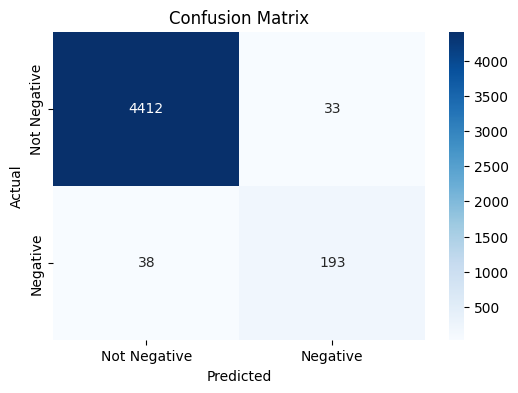

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Negative', 'Negative'], yticklabels=['Not Negative', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#HYPER PARAM TUNING XG BOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [1, 3, 5, 7]
}


xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_xgb_model = random_search.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)

from sklearn.metrics import classification_report
print("Classification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best Score: 0.7957129477387168
Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4445
           1       0.81      0.87      0.84       231

    accuracy                           0.98      4676
   macro avg       0.90      0.93      0.92      4676
weighted avg       0.98      0.98      0.98      4676



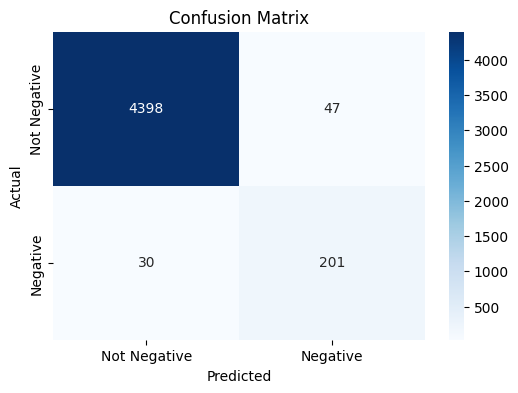

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


conf_matrix = confusion_matrix(y_test, y_pred_xgb_best)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Negative', 'Negative'], yticklabels=['Not Negative', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Feature Importance for XGboost


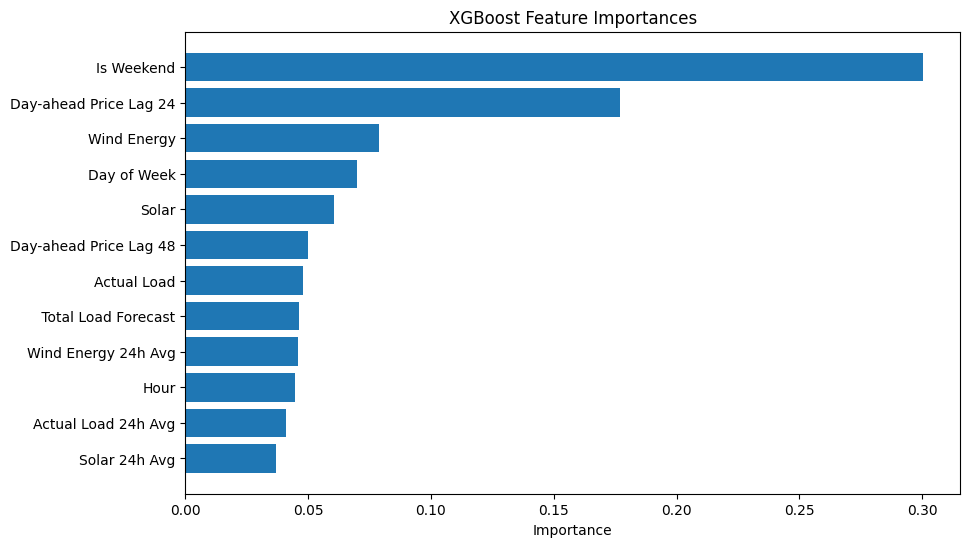

,Feature,Importance
11,Is Weekend,0.300472
3,Day-ahead Price Lag 24,0.176929
5,Wind Energy,0.078798
10,Day of Week,0.069998
0,Solar,0.060697
4,Day-ahead Price Lag 48,0.049919
2,Actual Load,0.048140
1,Total Load Forecast,0.046466
7,Wind Energy 24h Avg,0.045802
9,Hour,0.044639


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_xgb_model.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()

feature_importance_df


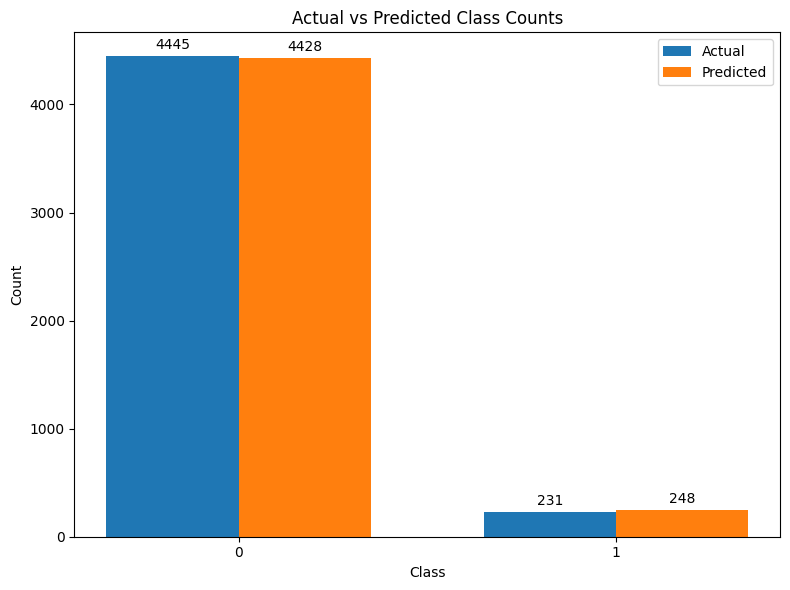

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb_best})

actual_counts = comparison_df['Actual'].value_counts().sort_index()
predicted_counts = comparison_df['Predicted'].value_counts().sort_index()

labels = actual_counts.index
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Class Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


#Standard Scaling

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Random Forest

In [ ]:

rf_classifier_smote = RandomForestClassifier(random_state=42)
rf_classifier_smote.fit(X_train_scaled, y_train)


y_pred_smote = rf_classifier_smote.predict(X_test_scaled)

classification_report_smote = classification_report(y_test, y_pred_smote)
print(classification_report_smote)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4445
           1       0.91      0.70      0.79       231

    accuracy                           0.98      4676
   macro avg       0.95      0.85      0.89      4676
weighted avg       0.98      0.98      0.98      4676



#Hyperparameter Tuning- Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=2)

random_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_rf_model = random_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best Score: 0.9912294316408458
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4445
           1       0.79      0.84      0.82       231

    accuracy                           0.98      4676
   macro avg       0.89      0.92      0.90      4676
weighted avg       0.98      0.98      0.98      4676



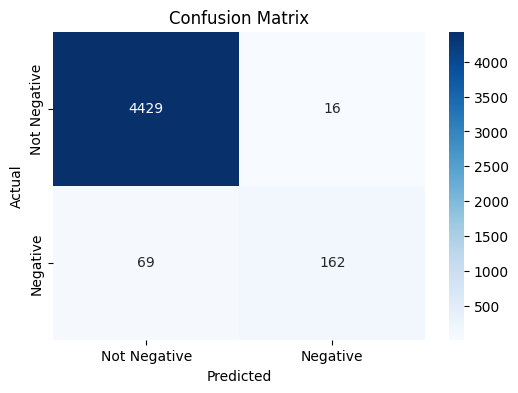

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Negative', 'Negative'], yticklabels=['Not Negative', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

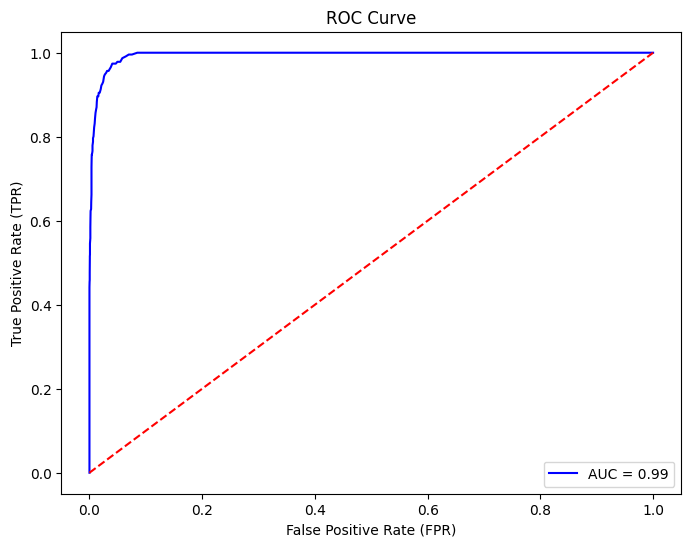

AUC Score: 0.99


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_prob = rf_classifier_smote.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC Score: {auc_score:.2f}')


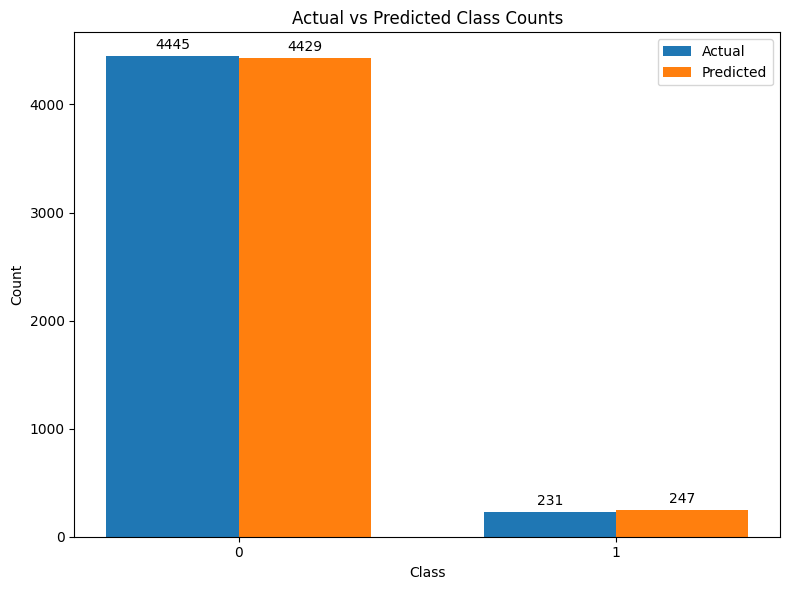

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

actual_counts = comparison_df['Actual'].value_counts().sort_index()
predicted_counts = comparison_df['Predicted'].value_counts().sort_index()


labels = actual_counts.index
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Class Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


#feature importance

In [ ]:
result = permutation_importance(rf_classifier_smote, X_test_scaled, y_test, n_repeats=10, random_state=42)

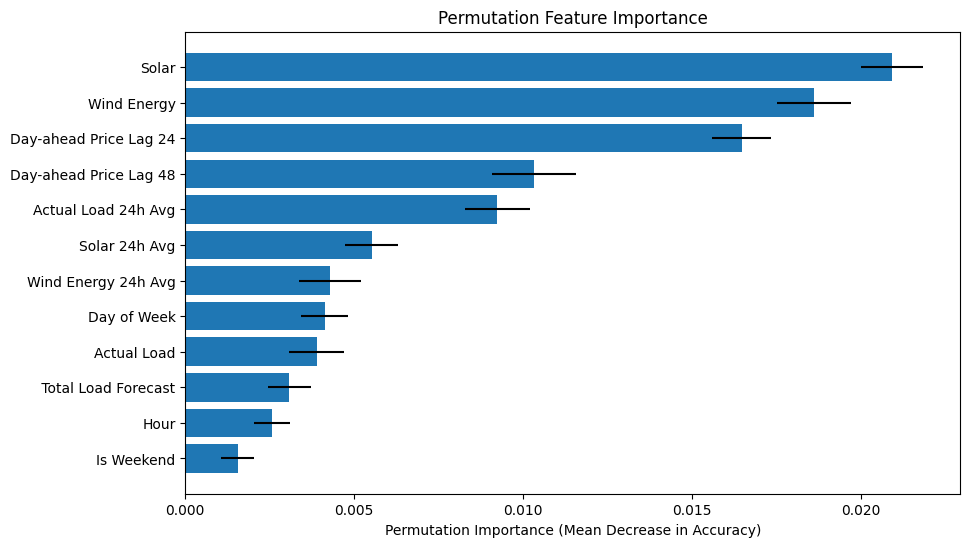

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


feature_names = X.columns
importances_mean = result.importances_mean
importances_std = result.importances_std

indices = np.argsort(importances_mean)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances_mean[indices], xerr=importances_std[indices], align='center')
plt.yticks(range(len(indices)), np.array(feature_names)[indices])
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


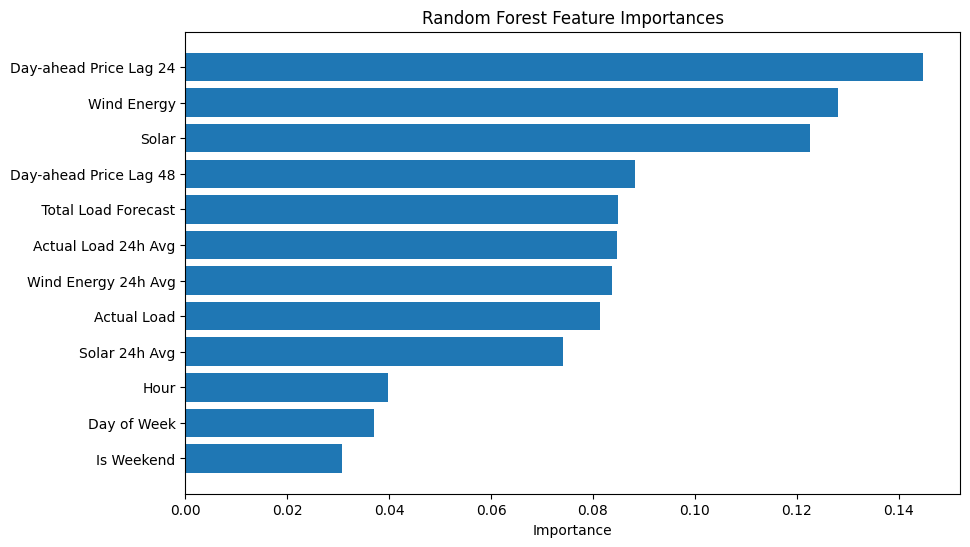

,Feature,Importance
3,Day-ahead Price Lag 24,0.144816
5,Wind Energy,0.128101
0,Solar,0.122513
4,Day-ahead Price Lag 48,0.088252
1,Total Load Forecast,0.084878
8,Actual Load 24h Avg,0.084663
7,Wind Energy 24h Avg,0.083640
2,Actual Load,0.081426
6,Solar 24h Avg,0.074197
9,Hour,0.039761


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf_classifier_smote.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
